# Preparations

In [1]:
import torch
import torchvision
import os.path

import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

from sklearn import manifold
from math import exp, sqrt
from torch.autograd import Variable
from my_dataset import MNIST_M
from my_dataset import ST_Dataset

%matplotlib inline
%load_ext skip_kernel_extension

In [2]:
use_gpu = torch.cuda.is_available()
print("use_gpu = " + str(use_gpu))

use_gpu = True


# Structure

![SVHN-MNIST Structure](https://c1.staticflickr.com/1/945/41945025492_f9db7ac20a_o.png)

In [3]:
import torch.nn as nn
import torch.nn.functional as F

class CNN(nn.Module):
    
    def __init__(self):
        super(CNN, self).__init__()
        self.C1 = nn.Conv2d(3, 96, kernel_size=5, padding=2)
        self.C2 = nn.Conv2d(96, 144, kernel_size=3, padding=1)
        self.C3 = nn.Conv2d(144, 256, kernel_size=5, padding=2)
        self.FC1 = nn.Linear(256 * 4 * 4, 512)
        self.FC2 = nn.Linear(512, 10)
        
    def forward(self, x):
        # C1
        x = F.relu(self.C1(x))
        # M1
        x = F.max_pool2d(x, (2, 2), stride=(2, 2))
        # C2
        x = F.relu(self.C2(x))
        # M2
        x = F.max_pool2d(x, (2, 2), stride=(2, 2))
        # C3
        x = F.relu(self.C3(x))
        # M3
        x = F.max_pool2d(x, (2, 2), stride=(2, 2))
        # x's size is (128, 256, 4, 4)
        # flatten
        x = x.view(-1, 256 * 4 * 4)
        f = x
        # FC1
        x = F.relu(self.FC1(x))
        lh = x
        # FC2
        x = self.FC2(x)
        return x, f, lh

In [4]:
cnn_svhn = CNN()
if (use_gpu):
    cnn_svhn.cuda()
print(cnn_svhn)

CNN(
  (C1): Conv2d(3, 96, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (C2): Conv2d(96, 144, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (C3): Conv2d(144, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (FC1): Linear(in_features=4096, out_features=512, bias=True)
  (FC2): Linear(in_features=512, out_features=10, bias=True)
)


In [5]:
def reset(model):
    for m in model.modules():
        if isinstance(m, nn.Conv2d):
            n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
            m.weight.data.normal_(0, sqrt(2 / n))
            if m.bias is not None:
                m.bias.data.zero_()
        elif isinstance(m, nn.Linear):
            size = m.weight.size()
            fan_out = size[0] # number of rows
            fan_in = size[1] # number of columns
            m.weight.data.normal_(0, sqrt(2 / (fan_in + fan_out)))
            m.bias.data.zero_()
        elif hasattr(m, 'reset_parameters'):
            m.reset_parameters()

# SVHN Dataset

In [6]:
import torchvision
import torchvision.transforms as transforms
import os.path

root_dir = "./data/"
data_dir = "svhn/"

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

batch_size = 128

trainset_svhn = torchvision.datasets.SVHN(os.path.join(root_dir, data_dir),
                                          split="train", transform=transform, download=True)
trainloader_svhn = torch.utils.data.DataLoader(trainset_svhn, batch_size=batch_size,
                                          shuffle=False, num_workers=0)
testset_svhn = torchvision.datasets.SVHN(os.path.join(root_dir, data_dir),
                                          split="test", transform=transform, download=True)
testloader_svhn = torch.utils.data.DataLoader(testset_svhn, batch_size=batch_size,
                                          shuffle=False, num_workers=0)


Using downloaded and verified file: ./data/svhn/train_32x32.mat
Using downloaded and verified file: ./data/svhn/test_32x32.mat


In [7]:
# this function takes the numpy input image with dim 3 x height x width
def convert_to_plt(input_image):
    input_image = input_image*np.asarray([0.5,0.5,0.5]) + np.asarray([0.5,0.5,0.5])
    return input_image

The 10th image in the first 128 images in the training set:


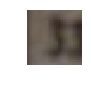

Its correspondent label:
tensor(3)


In [8]:
# randomly plot a sample from training set
import matplotlib.pyplot as plt

inputs = None
labels = None
for i, data in enumerate(trainloader_svhn):
    inputs, labels = data
    break

idx = np.random.randint(0, batch_size)
print("The " + str(idx) + "th image in the first " + str(batch_size) +\
      " images in the training set:")

plt_img = convert_to_plt(inputs[idx].permute(1, 2, 0).cpu().data.numpy())
plt.figure(figsize=(1,1))
plt.axis("off")
plt.imshow(plt_img)
plt.show()
print("Its correspondent label:\n" + str(labels[idx]))

## Training on MNIST

Or you can load the parameters directly.

In [37]:
import os.path
para_file = "./parameters/cnn3_svhn.pt"
if not os.path.exists('./parameters'):
    os.makedirs('./parameters')
load_model = os.path.isfile(para_file)
print("load_model = " + str(load_model))

load_model = False


In [38]:
%%skip (not $load_model)
cnn_svhn.load_state_dict(torch.load(para_file))

### Optimizer

In [39]:
import torch.optim as optim

lr_init = 0.01
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(cnn_svhn.parameters(), lr=lr_init, momentum=0.9)

def adjust_lr(optimizer, p):
    global lr_init
    lr_0 = lr_init
    alpha = 10
    beta = 0.75
    lr = lr_0 / (1 + alpha * p) ** beta
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

### Training process

In [40]:
%%skip $load_model

prev_loss = np.float("inf")
total_epoch = 20
reset(cnn_svhn)

for epoch in range(total_epoch):
    epoch_loss = 0.0
    running_loss = 0.0
    p = epoch * 1.0 / total_epoch
    adjust_lr(optimizer, p)
    for i, data in enumerate(trainloader_svhn):
        inputs, labels = data
        if (use_gpu):
            inputs, labels = inputs.cuda(), labels.cuda()
        inputs, labels = Variable(inputs), Variable(labels)
        optimizer.zero_grad()
        outputs, _, _ = cnn_svhn(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        running_loss += loss.item()
        if i % 50 == 49:    # print every 50 mini-batches
            print('[%3d] batch loss: %.3f' %
                  (i + 1, running_loss / 50))
            running_loss = 0.0
    print("epoch %d loss: %.3f -> %.3f\n" % (epoch + 1, prev_loss, epoch_loss))
    if prev_loss - epoch_loss < 0.1:
        break
    else:
        prev_loss = epoch_loss

[ 50] batch loss: 2.243
[100] batch loss: 2.187
[150] batch loss: 1.885
[200] batch loss: 1.206
[250] batch loss: 0.825
[300] batch loss: 0.671
[350] batch loss: 0.617
[400] batch loss: 0.534
[450] batch loss: 0.530
[500] batch loss: 0.499
[550] batch loss: 0.490
epoch 1 loss: inf -> 595.178

[ 50] batch loss: 0.431
[100] batch loss: 0.424
[150] batch loss: 0.409
[200] batch loss: 0.433
[250] batch loss: 0.391
[300] batch loss: 0.370
[350] batch loss: 0.357
[400] batch loss: 0.335
[450] batch loss: 0.340
[500] batch loss: 0.327
[550] batch loss: 0.336
epoch 2 loss: 595.178 -> 215.407

[ 50] batch loss: 0.317
[100] batch loss: 0.313
[150] batch loss: 0.299
[200] batch loss: 0.334
[250] batch loss: 0.292
[300] batch loss: 0.274
[350] batch loss: 0.276
[400] batch loss: 0.253
[450] batch loss: 0.265
[500] batch loss: 0.246
[550] batch loss: 0.260
epoch 3 loss: 215.407 -> 162.362

[ 50] batch loss: 0.254
[100] batch loss: 0.251
[150] batch loss: 0.243
[200] batch loss: 0.276
[250] batch lo

In [43]:
%%skip $load_model

torch.save(cnn_svhn.state_dict(), para_file)

## Testing on SVHN

In [12]:
def evaluate_accuracy(model, dataloader):
    model.eval()
    correct = 0
    total = 0
    for i, data in enumerate(dataloader):
        inputs, labels = data
        if (use_gpu):
            inputs, labels = inputs.cuda(), labels.cuda()
        with torch.no_grad():
            #inputs, labels = Variable(inputs, volatile=True), Variable(labels, volatile=True)
            inputs, labels = Variable(inputs), Variable(labels)
            outputs, _, _ = model(inputs)
            correct += (torch.max(outputs.data, 1)[1] == labels.data).sum().item()
            total += labels.size()[0]
    acc = correct * 1.0 / total
    return acc

In [41]:
print("Accuracy on SVHN test set (source only): " + str(evaluate_accuracy(cnn_svhn, testloader_svhn)))

Accuracy on MNIST test set (source only): 0.9085356484326982


# MNIST Dataset

In [14]:
batch_size = 128
root_dir = "./data/mnist/"

transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, ), (0.5, )),
    #transforms.Normalize((0.13066047712053577, ), (1, )),
    transforms.Lambda(lambda x: torch.cat((x, x, x), dim=0))
])

trainset = torchvision.datasets.MNIST(root_dir, train=True, transform=transform,
                                      target_transform=None, download=True)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=False, num_workers=0)
testset = torchvision.datasets.MNIST(root_dir, train=False, transform=transform,
                                      target_transform=None, download=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                          shuffle=False, num_workers=0)

The 17th image in the first 128 images in the training set:


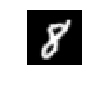

Its correspondent label:
tensor(8)


In [15]:
# randomly plot a sample from training set

inputs = None
labels = None
for i, data in enumerate(trainloader):
    inputs, labels = data
    break
    
idx = np.random.randint(0, batch_size)
print("The " + str(idx) + "th image in the first " + str(batch_size) +\
      " images in the training set:")

plt_img = convert_to_plt(inputs[idx].permute(1, 2, 0).cpu().data.numpy())
plt.figure(figsize=(1,1))
plt.axis("off")
plt.imshow(plt_img)
plt.show()
print("Its correspondent label:\n" + str(labels[idx]))

## Testing on MNIST-M Dataset (trained on source only)

In [42]:
print("Accuracy on MNIST-M test set (source only): " + str(evaluate_accuracy(cnn_svhn, testloader)))

Accuracy on MNIST-M test set (source only): 0.6043


## Visualization

In [17]:
from sklearn import manifold

def extract_features(model, dataloader):
    model.eval()
    features = None
    lasthidden = None
    labels = None
    for i, data in enumerate(dataloader):
        inputs, labels_ = data
        if (use_gpu):
            inputs = inputs.cuda()
        with torch.no_grad():
            inputs = Variable(inputs, requires_grad=False)
            _, f, l = model(inputs)
            if i == 0:
                features = f
                lasthidden = l
                labels = labels_
            else:
                features = torch.cat((features, f))
                lasthidden = torch.cat((lasthidden, l))
                labels = torch.cat((labels, labels_))
    features = features.data
    lasthidden = lasthidden.data
    if use_gpu:
        features = features.cpu()
        lasthidden = lasthidden.cpu()
    return features, lasthidden, labels

def visualize_single_dataset(data, labels, perplexity=50, sample_num=None):
    total_num = labels.shape[0]
    if sample_num:
        idx = np.random.choice(total_num, sample_num, replace=False)
        data, labels = data[idx, :], labels[idx]
        total_num = sample_num
    tsne = manifold.TSNE(n_components=2, init='random',
                     random_state=0, perplexity=perplexity)
    X = tsne.fit_transform(data)
    colors = ["red", "orange", "goldenrod", "yellow", "yellowgreen", "green", "teal", "blue", "violet", "purple"]
    for i in range(10):
        plt.scatter(X[labels == i, 0], X[labels == i, 1], c=colors[i], alpha=0.4)
    plt.axis("off")
    
def visualize_da(source, target, perplexity=50, sample_num=None, save=None):
    source_num = source.shape[0]
    target_num = target.shape[0]
    if sample_num:
        source, target = source[:sample_num, :], target[:sample_num, :]
        
    data = np.vstack((source, target))

    tsne = manifold.TSNE(n_components=2, init='random',
                         random_state=0, perplexity=perplexity)
    X = tsne.fit_transform(data)
    plt.scatter(X[:sample_num, 0], X[:sample_num, 1], c="blue", edgecolors=None, alpha=0.4)
    plt.scatter(X[sample_num:, 0], X[sample_num:, 1], c="red", edgecolors=None, alpha=0.4)
    plt.axis("off")
    if save:
        plt.savefig(save)
    plt.show()
    plt.clf()
    plt.close()

In [17]:
f_svhn, lh_svhn, l_svhn = extract_features(cnn_svhn, testloader_svhn)
f, lh, l = extract_features(cnn_svhn, testloader)

### Features of SVHN test set (extracted by source only model)

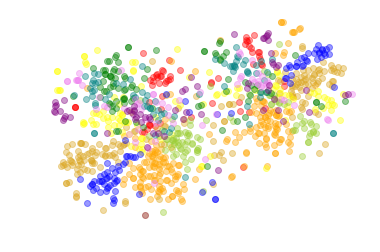

In [18]:
visualize_single_dataset(f_svhn.numpy(), l_svhn.numpy(), perplexity=50, sample_num=1000)

### Features of MNIST test set (extracted by source only model)

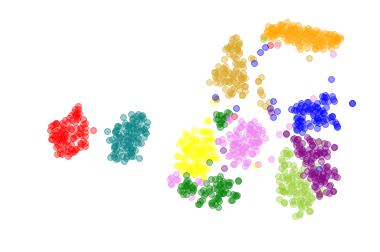

In [19]:
visualize_single_dataset(f.numpy(), l.numpy(), perplexity=50, sample_num=1000)

### Last hidden layer of SVHN test set (extracted by source only model)

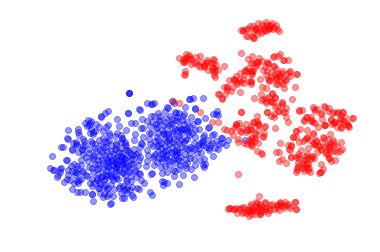

In [20]:
visualize_da(f_svhn.numpy(), f.numpy(), perplexity=50, sample_num=500,
             save="./pics/SVHN_to_MNIST_features_NonAdapted.svg")

### Last hidden layer of MNIST test set (extracted by source only model)

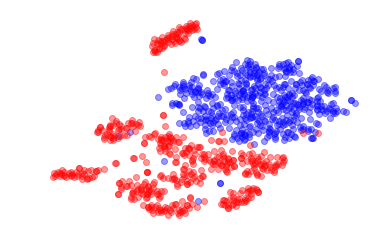

In [21]:
visualize_da(lh_svhn.numpy(), lh.numpy(), perplexity=50, sample_num=500,
             save="./pics/SVHN_to_MNIST_lasthidden_NonAdapted.svg")

## Training on MNIST Dataset

In [18]:
cnn = CNN()
if (use_gpu):
    cnn.cuda()
print(cnn)

CNN(
  (C1): Conv2d(3, 96, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (C2): Conv2d(96, 144, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (C3): Conv2d(144, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (FC1): Linear(in_features=4096, out_features=512, bias=True)
  (FC2): Linear(in_features=512, out_features=10, bias=True)
)


In [19]:
para_file = "./parameters/cnn3_mnist.pt"
load_model = os.path.isfile(para_file)
print("load_model = " + str(load_model))

load_model = True


In [20]:
%%skip (not $load_model)
cnn.load_state_dict(torch.load(para_file))

In [21]:
import torch.optim as optim

lr_init = 0.01
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(cnn.parameters(), lr=lr_init, momentum=0.9)

def adjust_lr(optimizer, p):
    global lr_init
    lr_0 = lr_init
    alpha = 10
    beta = 0.75
    lr = lr_0 / (1 + alpha * p) ** beta
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

In [27]:
%%skip $load_model

prev_loss = np.float("inf")
total_epoch = 50

for epoch in range(total_epoch):
    epoch_loss = 0.0
    running_loss = 0.0
    p = epoch * 1.0 / total_epoch
    adjust_lr(optimizer, p)
    for i, data in enumerate(trainloader):
        inputs, labels = data
        if (use_gpu):
            inputs, labels = inputs.cuda(), labels.cuda()
        
        
        inputs, labels = Variable(inputs), Variable(labels)
        optimizer.zero_grad()
        outputs, _, _ = cnn(inputs)
        loss = criterion(outputs, labels)
        
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        running_loss += loss.item()
        if i % 50 == 49:    # print every 50 mini-batches
            print('[%3d] batch loss: %.3f' %
                  (i + 1, running_loss / 50))
            running_loss = 0.0
    print("epoch %d loss: %.3f -> %.3f\n" % (epoch + 1, prev_loss, epoch_loss))
    if prev_loss - epoch_loss < 0.1:
        prev_loss = epoch_loss
        break
    else:
        prev_loss = epoch_loss

[ 50] batch loss: 2.179
[100] batch loss: 0.737
[150] batch loss: 0.230
[200] batch loss: 0.124
[250] batch loss: 0.124
[300] batch loss: 0.101
[350] batch loss: 0.105
[400] batch loss: 0.107
[450] batch loss: 0.064
epoch 1 loss: inf -> 189.650

[ 50] batch loss: 0.066
[100] batch loss: 0.066
[150] batch loss: 0.055
[200] batch loss: 0.041
[250] batch loss: 0.048
[300] batch loss: 0.051
[350] batch loss: 0.042
[400] batch loss: 0.050
[450] batch loss: 0.037
epoch 2 loss: 189.650 -> 23.489

[ 50] batch loss: 0.043
[100] batch loss: 0.045
[150] batch loss: 0.036
[200] batch loss: 0.027
[250] batch loss: 0.032
[300] batch loss: 0.036
[350] batch loss: 0.028
[400] batch loss: 0.033
[450] batch loss: 0.027
epoch 3 loss: 23.489 -> 15.893

[ 50] batch loss: 0.032
[100] batch loss: 0.029
[150] batch loss: 0.022
[200] batch loss: 0.019
[250] batch loss: 0.024
[300] batch loss: 0.027
[350] batch loss: 0.022
[400] batch loss: 0.024
[450] batch loss: 0.021
epoch 4 loss: 15.893 -> 11.613

[ 50] bat

In [28]:
%%skip $load_model

torch.save(cnn.state_dict(), para_file)

In [22]:
print("Accuracy on MNIST-M test set (train on target): " + str(evaluate_accuracy(cnn, testloader)))

Accuracy on MNIST-M test set (train on target): 0.9929


# Unsupervised Domain Adaptation

## Structure (GRL)

In [23]:
from my_dataset import ST_Dataset

In [24]:
batch_size = 128

trainset_da = ST_Dataset(trainset_svhn, trainset, batch_size)
trainloader_da = torch.utils.data.DataLoader(trainset_da, batch_size=batch_size,
                                          shuffle=False, num_workers=0)

The 48th image in the first 128 images in the training set:


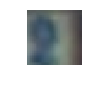

Its correspondent label:
2

From domain:
Source


In [25]:
# randomly plot a sample from test set

inputs = None
labels = None
for i, data in enumerate(trainloader_da):
    inputs, labels, domain = data
    if i == 2:
        break

idx = np.random.randint(0, batch_size)
print("The " + str(idx) + "th image in the first " + str(batch_size) +\
      " images in the training set:")
plt_img = convert_to_plt(inputs[idx].permute(1, 2, 0).cpu().data.numpy())
plt.figure(figsize=(1,1))
plt.axis("off")
plt.imshow(plt_img)
plt.show()
print("Its correspondent label:")
if labels[idx].item() == -1:
    print("I don't know :)\n")
else:
    print(str(labels[idx].item()) + "\n")

print("From domain:")
if domain[idx].item() == 0:
    print("Source")
else:
    print("Target")

In [26]:
class GRL_func(torch.autograd.Function):

    @staticmethod
    def forward(ctx, inputs, lamda):
        ctx.save_for_backward(lamda)
        return inputs

    @staticmethod
    def backward(ctx, grad_outputs):
        lamda, = ctx.saved_tensors
        return -lamda * grad_outputs, None

In [27]:
class GRL(nn.Module):
    
    def __init__(self, lamda_init):
        super(GRL, self).__init__()
        self.GRL_func = GRL_func.apply
        self.lamda = nn.Parameter(torch.Tensor(1), requires_grad=False)
        self.set_lamda(lamda_init)
        
    def forward(self, x):
        return self.GRL_func(x, self.lamda)
    
    def set_lamda(self, lamda_new):
        self.lamda[0] = lamda_new

![SVHN-MNIST Structure](https://c1.staticflickr.com/1/945/41945025492_f9db7ac20a_o.png)

In [28]:
class CNN_DA(nn.Module):
    
    def __init__(self, lamda_init=0):
        super(CNN_DA, self).__init__()
        # lamda
        self.lamda = lamda_init
        # feature extractor
        self.C1 = nn.Conv2d(3, 96, kernel_size=5, padding=2)
        self.C2 = nn.Conv2d(96, 144, kernel_size=5, padding=2)
        self.C3 = nn.Conv2d(144, 256, kernel_size=5, padding=2)
        # label classifier
        self.LC_FC1 = nn.Linear(256 * 4 * 4, 512)
        self.LC_FC2 = nn.Linear(512, 10)
        # domain classifier
        self.GRL_layer = GRL(lamda_init)
        self.DC_FC1 = nn.Linear(256 * 4 * 4, 1024)
        self.DC_FC2 = nn.Linear(1024, 1024)
        self.DC_FC3 = nn.Linear(1024, 1)
        
    def forward(self, x):
        # C1
        x = F.relu(self.C1(x))
        # M1
        x = F.max_pool2d(x, (2, 2), stride=(2, 2))
        # C2
        x = F.relu(self.C2(x))
        # M2
        x = F.max_pool2d(x, (2, 2), stride=(2, 2))
        # C3
        x = F.relu(self.C3(x))
        # M3
        x = F.max_pool2d(x, (2, 2), stride=(2, 2))
        # x's size is (128, 256, 4, 4)
        # flatten
        x = x.view(-1, 256 * 4 * 4)
        f = x
        # label classifier
        # LC_FC1
        x_l = F.relu(self.LC_FC1(x))
        lh = x_l
        # LC_FC2
        x_l = self.LC_FC2(x_l)
        # domain classifier
        # GRL
        x_d = self.GRL_layer(x)
        # DC_FC1
        x_d = F.relu(self.DC_FC1(x_d))
        # DC_FC2
        x_d = F.relu(self.DC_FC2(x_d))
        # DC_FC3
        x_d = F.sigmoid(self.DC_FC3(x_d))
        return x_l, x_d, f, lh
    
    def set_lamda(self, lamda_new):
        self.GRL_layer.set_lamda(lamda_new)

In [29]:
def extract_features_da(model, dataloader):
    features = None
    lasthidden = None
    labels = None
    for i, data in enumerate(dataloader):
        inputs, labels_ = data
        if (use_gpu):
            inputs = inputs.cuda()
        with torch.no_grad():
            inputs = Variable(inputs, requires_grad=False)
            _, _, f, l = model(inputs)
            if i == 0:
                features = f
                lasthidden = l
                labels = labels_
            else:
                features = torch.cat((features, f))
                lasthidden = torch.cat((lasthidden, l))
                labels = torch.cat((labels, labels_))
    features = features.data
    lasthidden = lasthidden.data
    if use_gpu:
        features = features.cpu()
        lasthidden = lasthidden.cpu()
    return features, lasthidden, labels

In [44]:
cnn_da = CNN_DA(0)
if (use_gpu):
    cnn_da.cuda()
print(cnn_da)

CNN_DA(
  (C1): Conv2d(3, 96, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (C2): Conv2d(96, 144, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (C3): Conv2d(144, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (LC_FC1): Linear(in_features=4096, out_features=512, bias=True)
  (LC_FC2): Linear(in_features=512, out_features=10, bias=True)
  (GRL_layer): GRL()
  (DC_FC1): Linear(in_features=4096, out_features=1024, bias=True)
  (DC_FC2): Linear(in_features=1024, out_features=1024, bias=True)
  (DC_FC3): Linear(in_features=1024, out_features=1, bias=True)
)


In [31]:
para_file_da = "./parameters/cnn_svhn_to_mnist.pt"
load_model_da = os.path.isfile(para_file_da)
print("load_model_da = " + str(load_model_da))

load_model_da = True


In [32]:
%%skip (not $load_model_da)
cnn_da.load_state_dict(torch.load(para_file_da))

### Optimizer

In [50]:
from math import exp

lr_init = 0.01
criterion_LC = nn.CrossEntropyLoss()
criterion_DC = nn.BCELoss()
optimizer = optim.SGD(filter(lambda p: p.requires_grad, cnn_da.parameters()), lr=lr_init, momentum=0.9)

def adjust_lr(optimizer, p):
    global lr_init
    lr_0 = lr_init
    alpha = 10
    beta = 0.75
    lr = lr_0 / (1 + alpha * p) ** beta
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr
    return lr
        
def adjust_lamda(model, p):
    gamma = 10
    lamda = 2 / (1 + exp(- gamma * p)) - 1
    model.set_lamda(lamda)
    return lamda

### Training process

In [51]:
#%%skip $load_model_da

prev_loss = np.float("inf")
prev_loss_LC = np.float("inf")
prev_loss_DC = np.float("inf")
total_epoch = 30
reset(cnn_da)

for epoch in range(total_epoch):
    epoch_loss = 0.0
    running_loss = 0.0
    epoch_loss_LC = 0.0
    epoch_loss_DC = 0.0
    p = epoch * 1.0 / total_epoch
    # adjust_lr(optimizer, p)
    lamda = adjust_lamda(cnn_da, p)
    for i, data in enumerate(trainloader_da):
        # get inputs
        source_size = data[0].size()[0] // 2
        inputs, labels, domains = data
        domains = domains.to(torch.float32)
        if (use_gpu):
            inputs, labels, domains = inputs.cuda(), labels.cuda(), domains.cuda()
        inputs, labels, domains = Variable(inputs), Variable(labels), Variable(domains)
        optimizer.zero_grad()
        # forward
        outputs_LC, outputs_DC, f, l = cnn_da(inputs)
        # compute loss
        outputs_DC = outputs_DC.view(-1)
        loss_LC = criterion_LC(outputs_LC[:source_size], labels[:source_size])
        loss_DC = criterion_DC(outputs_DC, domains)
        loss = loss_LC + loss_DC
        # backward
        loss.backward()
        optimizer.step()
        # stat
        epoch_loss += loss.item()
        running_loss += loss.item()
        epoch_loss_LC += loss_LC.item()
        epoch_loss_DC += loss_DC.item()
        if i % 50 == 49:    # print every 50 mini-batches
            print('[%3d] batch loss: %.3f' %
                  (i + 1, running_loss / 50))
            running_loss = 0.0
#     f_da, lh_da, _ = extract_features_da(cnn_da, testloader)
#     f_m_da, lh_m_da, _ = extract_features_da(cnn_da, testloader_m)
#     visualize_da(f_da.numpy(), f_m_da.numpy(), perplexity=30, sample_num=200,
#                  save="./pics/f_" + str(epoch + 1) + ".svg")
#     visualize_da(lh_da.numpy(), lh_m_da.numpy(), perplexity=30, sample_num=200,
#                  save="./pics/lh_" + str(epoch + 1) + ".svg")
    print("epoch %d loss: %.3f -> %.3f" % (epoch + 1, prev_loss, epoch_loss))
    print("LC loss: %.3f -> %.3f" % (prev_loss_LC, epoch_loss_LC))
    print("DC loss: %.3f -> %.3f" % (prev_loss_DC, epoch_loss_DC))
    print(("Label classifier accuracy on MNIST test set (DA): %f\n"
           "Domain classifier accuracy on MNIST test set (DA): %f\n")
          %evaluate_da_accuracy(cnn_da, testloader, source=False))
    if prev_loss - epoch_loss < 0.1:
        prev_loss = epoch_loss
        prev_loss_LC = epoch_loss_LC
        prev_loss_DC = epoch_loss_DC
        pass
    else:
        prev_loss = epoch_loss
        prev_loss_LC = epoch_loss_LC
        prev_loss_DC = epoch_loss_DC

[ 50] batch loss: 2.667
[100] batch loss: 2.236
[150] batch loss: 1.857
[200] batch loss: 1.161
[250] batch loss: 0.869
[300] batch loss: 0.732
[350] batch loss: 0.711
[400] batch loss: 0.611
[450] batch loss: 0.587
[500] batch loss: 0.565
[550] batch loss: 0.534
[600] batch loss: 0.504
[650] batch loss: 0.487
[700] batch loss: 0.486
[750] batch loss: 0.447
[800] batch loss: 0.450
[850] batch loss: 0.475
[900] batch loss: 0.437
epoch 1 loss: inf -> 806.050
LC loss: inf -> 768.382
DC loss: inf -> 37.668
Label classifier accuracy on MNIST test set (DA): 0.509900
Domain classifier accuracy on MNIST test set (DA): 0.997260

[ 50] batch loss: 0.397
[100] batch loss: 0.424
[150] batch loss: 0.403
[200] batch loss: 0.369
[250] batch loss: 0.361
[300] batch loss: 0.379
[350] batch loss: 0.423
[400] batch loss: 0.370
[450] batch loss: 0.337
[500] batch loss: 0.335
[550] batch loss: 0.323
[600] batch loss: 0.308
[650] batch loss: 0.317
[700] batch loss: 0.301
[750] batch loss: 0.277
[800] batch 

[ 50] batch loss: 0.024
[100] batch loss: 0.019
[150] batch loss: 0.033
[200] batch loss: 0.022
[250] batch loss: 0.023
[300] batch loss: 0.014
[350] batch loss: 0.034
[400] batch loss: 0.020
[450] batch loss: 0.030
[500] batch loss: 0.022
[550] batch loss: 0.026
[600] batch loss: 0.019
[650] batch loss: 0.027
[700] batch loss: 0.023
[750] batch loss: 0.019
[800] batch loss: 0.020
[850] batch loss: 0.019
[900] batch loss: 0.014
epoch 14 loss: 20.854 -> 21.259
LC loss: 20.304 -> 19.929
DC loss: 0.550 -> 1.329
Label classifier accuracy on MNIST test set (DA): 0.634700
Domain classifier accuracy on MNIST test set (DA): 0.998066

[ 50] batch loss: 0.012
[100] batch loss: 0.025
[150] batch loss: 0.015
[200] batch loss: 0.016
[250] batch loss: 0.015
[300] batch loss: 0.020
[350] batch loss: 0.029
[400] batch loss: 0.018
[450] batch loss: 0.020
[500] batch loss: 0.016
[550] batch loss: 0.018
[600] batch loss: 0.026
[650] batch loss: 0.017
[700] batch loss: 0.019
[750] batch loss: 0.014
[800] 

[ 50] batch loss: 0.003
[100] batch loss: 0.005
[150] batch loss: 0.010
[200] batch loss: 0.008
[250] batch loss: 0.004
[300] batch loss: 0.006
[350] batch loss: 0.017
[400] batch loss: 0.012
[450] batch loss: 0.016
[500] batch loss: 0.013
[550] batch loss: 0.007
[600] batch loss: 0.003
[650] batch loss: 0.005
[700] batch loss: 0.003
[750] batch loss: 0.009
[800] batch loss: 0.007
[850] batch loss: 0.010
[900] batch loss: 0.003
epoch 27 loss: 6.218 -> 7.147
LC loss: 6.146 -> 6.944
DC loss: 0.072 -> 0.203
Label classifier accuracy on MNIST test set (DA): 0.640000
Domain classifier accuracy on MNIST test set (DA): 0.999583

[ 50] batch loss: 0.002
[100] batch loss: 0.003
[150] batch loss: 0.006
[200] batch loss: 0.003
[250] batch loss: 0.014
[300] batch loss: 0.023
[350] batch loss: 0.014
[400] batch loss: 0.016
[450] batch loss: 0.007
[500] batch loss: 0.010
[550] batch loss: 0.006
[600] batch loss: 0.017
[650] batch loss: 0.013
[700] batch loss: 0.007
[750] batch loss: 0.018
[800] batc

In [94]:
%%skip $load_model_da

torch.save(cnn_da.state_dict(), para_file_da)

### Test on SVHN and MNIST dataset

In [34]:
def evaluate_da_accuracy(model, dataloader, source):
    model.eval()
    correct_LC = 0
    correct_DC = 0
    total = 0
    
    with torch.no_grad():
        for i, data in enumerate(dataloader):
            inputs, labels = data
            if (use_gpu):
                inputs, labels = inputs.cuda(), labels.cuda()
            inputs, labels = Variable(inputs), Variable(labels)
            outputs_LC, outputs_DC, _, _ = model(inputs)
            correct_LC += (torch.max(outputs_LC.data, 1)[1] == labels.data).sum().item()
            if source:
                correct_DC += labels.size()[0] - outputs_DC.data.sum().item()
            else:
                correct_DC += outputs_DC.data.sum().item()
            total += labels.size()[0]
        acc_LC = correct_LC / total
        acc_DC = correct_DC / total
    return acc_LC, acc_DC

In [35]:
print(("Label classifier accuracy on SVHN test set (DA): %f\n"
       "Domain classifier accuracy on SVHN test set (DA): %f")
      %evaluate_da_accuracy(cnn_da, testloader_svhn, source=True))

Label classifier accuracy on SVHN test set (DA): 0.919215
Domain classifier accuracy on SVHN test set (DA): 0.999045


In [36]:
print(("Label classifier accuracy on MNIST test set (DA): %f\n"
       "Domain classifier accuracy on MNIST test set (DA): %f")
      %evaluate_da_accuracy(cnn_da, testloader, source=False))

Label classifier accuracy on MNIST test set (DA): 0.697800
Domain classifier accuracy on MNIST test set (DA): 1.000000


### Visualization

In [95]:
f_svhn_da, lh_svhn_da, l_svhn_da = extract_features_da(cnn_da, testloader_svhn)
f_da, lh_da, l_da = extract_features_da(cnn_da, testloader)

Features of MNIST test set (extracted by DA model)

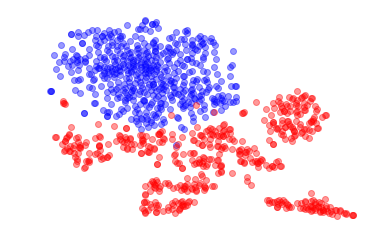

In [96]:
visualize_da(f_svhn_da.numpy(), f_da.numpy(), perplexity=50, sample_num=500,
             save="./pics/SVHN_to_MNIST_features_Adapted.svg")

Features of MNIST-M test set (extracted by DA model)

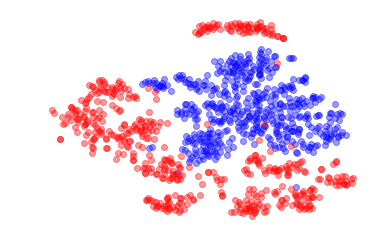

In [97]:
visualize_da(lh_svhn_da.numpy(), lh_da.numpy(), perplexity=50, sample_num=500,
             save="./pics/SVHN_to_MNIST_lasthidden_Adapted.svg")